In [1]:
# General imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.constants as const
import astropy.units as u

%config InlineBackend.figure_format ='retina'


In [2]:
# TARDIS imports for the gamma-ray code
from tardis.io.atom_data import AtomData
from tardis.model import SimulationState
from tardis.plasma.base import BasePlasma
from tardis.io.configuration import config_reader
from tardis.energy_input.main_gamma_ray_loop import run_gamma_ray_loop
from tardis.plasma.properties import Density, Abundance, IsotopeAbundance, \
    IsotopeNumberDensity, AtomicData, AtomicMass, IsotopeMass, NumberDensity, \
    SelectedAtoms

/Users/anirbandutta/Software/tardis/tardis/__init__.py:20: UserWarning: Astropy is already imported externally. Astropy should be imported after TARDIS.
  warnings.warn(


Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [3]:
# Download the atom data file from tardis-refdata repo to run this cell.
atom_data_file = '/Users/anirbandutta/Software/tardis-refdata/atom_data/kurucz_cd23_chianti_H_He.h5'
atom_data = AtomData.from_hdf(atom_data_file)

INFO:tardis.io.atom_data.base:Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace 
INFO:tardis.io.atom_data.base:Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data, linelist


In [4]:
# Read the config file and create a configuration object
config = config_reader.Configuration.from_yaml("/Users/anirbandutta/Projects/gamma_ray_tardis/tardis_configv1_density_exponential_nebular_Ni_only.yml")

In [5]:
# Create the model
model = SimulationState.from_config(config, atom_data)


INFO:tardis.model.matter.decay:Decaying abundances for 12960000.0 seconds
/Users/anirbandutta/Software/tardis/tardis/model/matter/composition.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '9.288214564694115e-23' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  isotope_mass_df[isotope_tuple] = isotope_mass


In [6]:
# This shows the isotope abundances in the model before decay
model.composition.raw_isotope_abundance

,,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
atomic_number,mass_number,,,,,,,,,,,,,,,,,,,,
28,56,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167,0.479167


In [7]:
# Construct the Plasma

input = [Density, Abundance, IsotopeAbundance, AtomicData, AtomicMass, IsotopeNumberDensity, NumberDensity, SelectedAtoms, IsotopeMass]

plasma = BasePlasma(plasma_properties=input, density = model.density, 
                    abundance=model.abundance, isotope_abundance=model.composition.raw_isotope_abundance,
                    atomic_data = atom_data)

In [8]:
# Define the number of MC packets
num_packets =  100000

np.random.seed(1)

In [9]:
# Execute this cell to run the simulation
energy_df, energy_plot_df, escape_energy, decayed_packet_count, energy_plot_positrons, \
       energy_estimated_deposition, packets_df =  run_gamma_ray_loop(model, plasma, num_decays=num_packets, 
                                         time_start=0.0011574074, time_end=20.0, time_space="log", 
                                         time_steps=50, seed=1, positronium_fraction=0.0,
                                         spectrum_bins=1000, grey_opacity=-1, 
                                         path_to_decay_data=atom_data_file)

INFO:tardis.energy_input.main_gamma_ray_loop:Total gamma-ray energy is 2.2720351391575986e+45
INFO:tardis.energy_input.main_gamma_ray_loop:Total number of packets is 100001
INFO:tardis.energy_input.main_gamma_ray_loop:Energy per packet is 2.272012419033408e+40
INFO:tardis.energy_input.main_gamma_ray_loop:Initializing packets
INFO:tardis.energy_input.gamma_ray_transport:Isotope packet count dataframe
INFO:tardis.energy_input.gamma_ray_transport:element
Co-56    7514
Ni-56    2327
Name: 0, dtype: int64
INFO:tardis.energy_input.gamma_ray_transport:element
Co-56    6997
Ni-56    2167
Name: 1, dtype: int64
INFO:tardis.energy_input.gamma_ray_transport:element
Co-56    6495
Ni-56    2011
Name: 2, dtype: int64
INFO:tardis.energy_input.gamma_ray_transport:element
Co-56    6013
Ni-56    1862
Name: 3, dtype: int64
INFO:tardis.energy_input.gamma_ray_transport:element
Co-56    5553
Ni-56    1719
Name: 4, dtype: int64
INFO:tardis.energy_input.gamma_ray_transport:element
Co-56    5115
Ni-56    1584
N

Entering gamma ray loop for 100001 packets
Escaped packets: 39018
Scattered packets: 9792


In [10]:
# To construct the gamma-ray spectrum, we need to collect the packets that escaped the ejecta
# escaped packets ahve status '5'

packets_df_escaped = packets_df[(packets_df['status'] == 5)]

In [11]:
# See Noebauer and Sim (2019) for more details

H_CGS_KEV = const.h.to("keV s").value
freq_start = packets_df_escaped['nu_rf'].min()
freq_stop = packets_df_escaped['nu_rf'].max()
N = 500
spectrum_frequency = np.linspace(freq_start, freq_stop, N+1)

emitted_luminosity_hist = np.histogram(packets_df_escaped['nu_rf'],
                                    weights=packets_df_escaped['lum_rf'],
                                        bins=spectrum_frequency)[0]

spectrum_frequency = spectrum_frequency[:-1]
delta_frequency = spectrum_frequency[1] - spectrum_frequency[0]   

luminosity_density = emitted_luminosity_hist / delta_frequency
flux = luminosity_density / (4. * np.pi * (10.0 * u.pc).to("cm").value ** 2.0)
photon_energy = spectrum_frequency * H_CGS_KEV * 0.001


(0.07, 9)

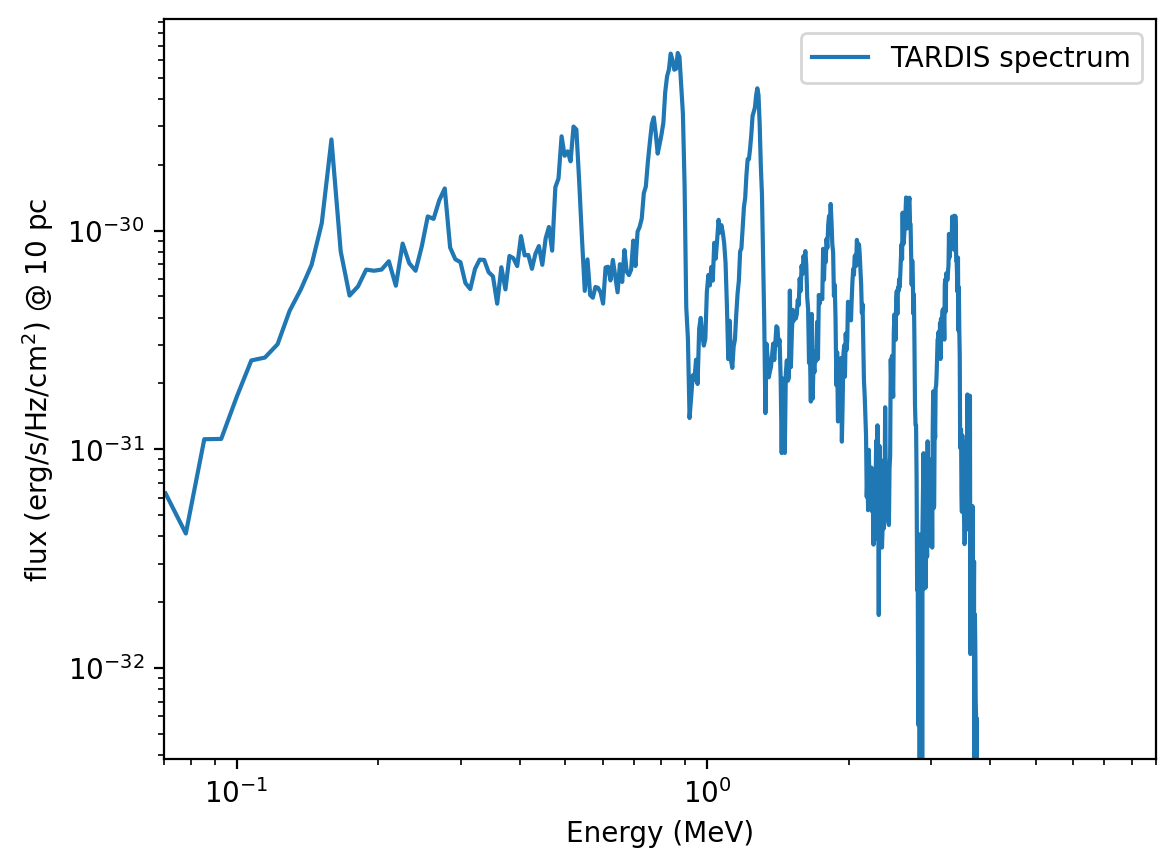

In [12]:
plt.plot(photon_energy, flux, label='TARDIS spectrum')
#plt.plot(hesma_model_vm.index, hesma_model_vm['30.10'], label='Hesma 30.10', alpha=0.7)

plt.loglog()
plt.xlabel("Energy (MeV)")
plt.ylabel(r"flux (erg/s/Hz/cm$^{2}$) @ 10 pc")

plt.legend(loc='best')
plt.xlim(0.07, 9)